# Playground notebook

## Imports and settings

In [25]:
import src

import os
import numpy as np
import sys
import re
import pickle
import math
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from  matplotlib.animation import FuncAnimation
from matplotlib import colors
from netCDF4 import Dataset
from IPython.display import clear_output
#data folder
sys.path.insert(0, 'C:/Users/pkicsiny/Desktop/TUM/3/ADL4CV/data')

#forces CPU usage
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "1" #"" for CPU
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4422596724912418874
]


______________________________________-
## Data preprocessing

### Rain measurements
Measurements are downloaded from the DWD (German weather service) open data server: __ftp://ftp-cdc.dwd.de/pub/CDC/grids_germany/hourly/__<br>
I'm working with the data of August 2010 (based on [this](https://tradingeconomics.com/germany/precipitation)), so I have downloaded this: __ftp://ftp-cdc.dwd.de/pub/CDC/grids_germany/hourly/radolan/historical/asc/2010/RW-201008.tar__<br>
_DWD manual:_<br>
__ftp://ftp-cdc.dwd.de/pub/CDC/grids_germany/hourly/radolan/historical/asc/BESCHREIBUNG_gridsgermany_hourly_radolan_historical_asc_de.pdf__<br><br>
This contains radar maps recorded in every hour. Each map has a resolution of $900\times900$ pixels and each pixel corresponds to an $1\,km\times1\,km$ area in reality. Pixel values are the precipitation height in $0.1\,mm$.
Below I'm importing the data of this as a series of numpy arrays and plot them to see the acual radar map. The _sys.path[0]_ is the path on my computer and it can be different for you.
<br>
The data with hourly resolutions spans from 1995 to 2012.<br><br>
Additionally there is data with 5 minutes resolution available here: 
https://opendata.dwd.de/weather/radar/composit/rx/<br>
The span of this is the last two days and it is updated constantly.

In [ ]:
inputs = src.get_data(sys.path[0]+"/rain_hourly", which="h",total_length=40, mask=True)

### Wind measurements
Here I'm loading wind measurements. This is important because later we might experiment not only with rain (the density field) but with the wind (velocity field) too. This is because in the tempoGAN paper they also use the velocity and without it that might be very difficult to build the GAN (unless you have some other ideas). So for now I'll try this way. I have downloaded two datasets for the wind:<br><br>
_Wind direction:_ __ftp://ftp-cdc.dwd.de/pub/CDC/grids_germany/hourly/Project_TRY/wind_direction/DD_201208.nc.gz__<br>
_Wind speed:_ __ftp://ftp-cdc.dwd.de/pub/CDC/grids_germany/hourly/Project_TRY/wind_speed/FF_201208.nc.gz__<br>
_DWD manuals:_<br>
__ftp://ftp-cdc.dwd.de/pub/CDC/grids_germany/hourly/Project_TRY/wind_direction/DESCRIPTION_gridsgermany_hourly_Project_TRY_wind_direction_en.pdf__
<br>
__ftp://ftp-cdc.dwd.de/pub/CDC/grids_germany/hourly/Project_TRY/wind_speed/DESCRIPTION_gridsgermany_hourly_Project_TRY_wind_speed_en.pdf__<br><br>
I create two datasets out of these. They contain the $x$ and $y$ velocity components.
The measurements are in $\displaystyle0.1\,\frac{m}{s}$.
<br><br>
_<font color='red'>__Issue__:</font> [Mostly](https://www.nationalgeographic.com/science/earth/earths-atmosphere/clouds/) an average rain cloud is at $2000\,m$ high. Normal clouds can be up to $6000\,m$ high. We only have wind measurements recorded at $10\,m$. 
We can use e.g. [this](https://websites.pmc.ucsc.edu/~jnoble/wind/extrap/) to calculate wind speed at higher altitudes. We can't correct the change in wind direction so this remains a weak point in the simulations._

In [ ]:
#the paths are probably different for you
w_dir = Dataset(sys.path[0]+'/wind_direction/DD_201008_CF.nc')  # direction
w_vel = Dataset(sys.path[0]+'/wind_speed/FF_201008_CF.nc')  # velocity
#cloud = Dataset(sys.path[0]+'/cloud/N_201008_CF.nc')['CF']  # cloud cover

Read wind direction and magnitude datasets. They are hourly distributed and I use the dataset of 2010. August. There are 744 = 24$\cdot$31 maps, each 938*720 pixels.

In [ ]:
#creating vx and vy datasets from |v| and phi
vx = np.ma.masked_where(np.ma.getmask(w_dir['DD'][:144]), np.zeros(w_dir['DD'][:144].shape))
vy = np.ma.masked_where(np.ma.getmask(w_dir['DD'][:144]), np.zeros(w_dir['DD'][:144].shape))
for t in range(np.shape(vx)[0]):
    src.update_output(f"[{t+1}/{np.shape(vx)[0]}]")
    vx[t] = np.flip(np.sin(np.deg2rad(w_dir['DD'][600+t])),axis = 0)
    vy[t] = np.flip(np.cos(np.deg2rad(w_dir['DD'][600+t])),axis = 0)

In [ ]:
#gps grid of wind maps
#47.075
wind_grid = pd.DataFrame(data={'LAT':w_vel['lat'][:].flatten(),
                               'LON':w_vel['lon'][:].flatten()}).reset_index().rename(columns={"index":"CELL_ID"})

In [ ]:
#sanity checks
%matplotlib notebook
idx = 0
fig = plt.figure(figsize=(14,14))
# NE, N, NW
plt.subplot(2,2,1)
plt.imshow(np.ma.masked_where(vy[idx] < 0, vy[idx]))
plt.colorbar(shrink=0.7)
plt.title("All northern wind")

plt.subplot(2,2,2)
plt.imshow(np.flip(np.ma.masked_where((w_dir['DD'][idx]>=90)& (w_dir['DD'][idx]<=270),w_dir['DD'][idx] ), axis=0))
plt.colorbar(shrink=0.7)
plt.title("All northern wind truth")

# SW
plt.subplot(2,2,3)
plt.imshow(np.ma.masked_where((vy[idx]>0)|(vx[idx]>0), vy[idx]))
plt.colorbar(shrink=0.7)
plt.title("Southwestern wind")

plt.subplot(2,2,4)
plt.imshow(np.flip(np.ma.masked_where((w_dir['DD'][idx]<180)| (w_dir['DD'][idx]>270),w_dir['DD'][idx] ), axis=0))
plt.colorbar(shrink=0.7)
plt.title("Southwestern wind truth")

plt.subplots_adjust(hspace=0.3, wspace=0.3)

### Radar coordinates
The gps coordinates of the radar grid for the rain measurements.

In [ ]:
coords = src.get_rain_grid_coords()

In [ ]:
reduced_coords = coords[coords["LON"]>= germany["LON"].min()]
reduced_coords

### Germany
GPS coordinates of Germany. This is a subset of the wind grid. As next I'm matching wind grid cells with the nearest rain cells. As seen on the plot below, the rain and wind data comes from a different radar measurement method so they have a different grid map so the grid points are not identical.

In [ ]:
with open('germany.pickle', 'rb') as handle:
    germany = pickle.load(handle)
germany

In [ ]:
%matplotlib notebook
idx_test = 277777

#plt.scatter(wind_grid["LON"],wind_grid["LAT"],s=0.2, label="wind grid")
plt.scatter(reduced_coords["LON"],
            reduced_coords["LAT"],s=0.2, label="rain grid")
#plt.scatter(germany["LON"],germany["LAT"],s=0.2, label="wind grid")


plt.scatter(germany["LON"],germany["LAT"],s=10, label="wind grid")
plt.scatter(coords.iloc[germany["CLOSEST_RAIN_CELL_ID"]]["LON"],
            coords.iloc[germany["CLOSEST_RAIN_CELL_ID"]]["LAT"],
            s=10, label="rain grid")
#plt.scatter(germany["LON"],germany["LAT"],s=0.2, label="Germany")
plt.xlabel("LON")
plt.ylabel("LAT")
lgnd = plt.legend(loc="lower right")
lgnd.legendHandles[0]._sizes = [30]
lgnd.legendHandles[1]._sizes = [30]
#lgnd.legendHandles[2]._sizes = [30]

Create density channel (rain) with the grid of the wind maps. We need 3 channels: [rain,vx,vy]<br>
Since the wind data is available until the end of 2012, we can only create three channels using the hourly resolution. 5 min data is available only for the past 48 hours.

In [ ]:
rho = np.ma.masked_where(np.flip(np.ma.getmask(w_dir['DD'][:144]),axis=1),
                         np.zeros((144,w_dir['DD'].shape[1],w_dir['DD'].shape[2])))
rho[:,938-germany["CELL_ID"]//720,
    germany["CELL_ID"]%720] = inputs[600:,900-germany["CLOSEST_RAIN_CELL_ID"]//900, germany["CLOSEST_RAIN_CELL_ID"]%900]
rho.shape

In [ ]:
rho.shape

In [ ]:
%matplotlib notebook
idx = 45
plt.subplot(1,3,1)
plt.imshow(np.ma.masked_where(inputs[200+idx] < 0,inputs[200+idx]))
plt.title("RADOLAN rain")
plt.subplot(1,3,2)
plt.imshow(rho[idx])
plt.title("Interpolated rain")
plt.subplot(1,3,3)
plt.imshow(vy[idx])
plt.title("Wind")
plt.show()

In [ ]:
new = np.ma.concatenate((a["field"][:], rho), axis=0)

In [ ]:
#root_grp.close()
root_grp = Dataset('rho.nc', 'w', format='NETCDF4')
root_grp.description = 'Example simulation data'

lat_n = 938
lon_n = 720
xdimension = 0.75
ydimension = 0.75
# dimensions
root_grp.createDimension('time', None)
root_grp.createDimension('lat', lat_n)
root_grp.createDimension('lon', lon_n)

# variables
time = root_grp.createVariable('time', 'c', ('time',))
x = root_grp.createVariable('lat', 'c', ('lat',))
y = root_grp.createVariable('lon', 'c', ('lon',))
field = root_grp.createVariable('field', 'f4', ('time', 'lat', 'lon',))

field[:,:,:] = new

root_grp.close()

In [41]:
a = Dataset(sys.path[0]+"/rain_density/rho.nc")

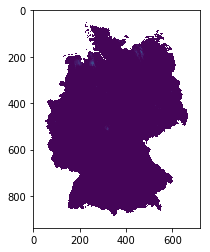

In [42]:
plt.imshow(a["field"][743])

In [ ]:
# look over the data
%matplotlib notebook
from  matplotlib.animation import FuncAnimation

fig = plt.figure()
plot = plt.imshow(np.ma.masked_where(inputs[0] < 0, inputs[0])) #inputs 100 has a good mask
def update(i):
    plot.set_data(np.ma.masked_where(inputs[0] < 0, inputs[i]))
    plt.title(i)
    return plot

anim = FuncAnimation(fig, update, frames=744, interval = 100, blit=True, repeat=False)

plt.show()

In [39]:
 # These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

    # Get a sorted list of the objects and their sizes
sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)

[('FuncAnimation', 1056),
 ('Dataset', 400),
 ('clear_output', 136),
 ('memory', 136),
 ('colors', 80),
 ('device_lib', 80),
 ('np', 80),
 ('pd', 80),
 ('plt', 80),
 ('sns', 80),
 ('tf', 80),
 ('n', 28),
 ('a', 24),
 ('inputs', 24)]